## Data Analysis
This notebook will be used to analyse data from Combination Lock experiments.

### Install Libraries

In [1]:
%%capture

%pip install matplotlib
%pip install pandas statsmodels
import json
import glob
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
%matplotlib inline
import matplotlib as mpl
import pandas as pd
from statsmodels.stats.anova import AnovaRM


### Read in Files

In [2]:
log_dir = './docs/evaluation-logs/*'
filepaths = glob.glob(log_dir)

files = []

for path in filepaths:
    with open(path) as f:
        files.append(json.load(f)['data'])

### Extract Data Across Participants into Single Dict

In [3]:
fullDict = {}


for f in files:
    fullDict = fullDict | f

print(len(fullDict))

66


### Traverse entire dataset, adding each list to the appropraite method list

In [4]:
methodsDict = {'tap6':[], 'tap10':[], 'direction6':[], 'direction10':[], 'pin':[],'pattern':[]}

for key in fullDict.keys():
    method = fullDict[key][0]['method']
    numTicks = fullDict[key][0]['numTicks']

    if method == 'tap':
        if numTicks == '6':
            methodsDict['tap6'] += fullDict[key]
        else:
            methodsDict['tap10'] += fullDict[key]
    elif  method == 'direction':
        if numTicks == '6':
            methodsDict['direction6'] += fullDict[key]
        else:
            methodsDict['direction10'] += fullDict[key]
    elif method == 'PATTERN':
        methodsDict['pattern'] += fullDict[key]
    elif method == 'PIN':
        methodsDict['pin'] += fullDict[key]
    
# Remove Abortions
for key in methodsDict:
    methodsDict[key] = list(filter(lambda x:x['endState'] != 'ABORTED', methodsDict[key]))

### Graph Average Success Rate For Each Method

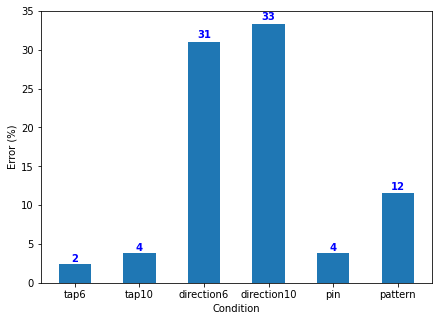

In [5]:
errorRates = {}

def computeErrorRate(lst):
    errors = len(list(filter(lambda x: x['endState'] == 'FAILURE', lst)))
    return (errors / len(lst)) * 100

for method in methodsDict:
    errorRates[method] = computeErrorRate(methodsDict[method])


fig, ax = plt.subplots(figsize=(7,5))
ax.set_ylabel('Error (%)')
ax.set_xlabel('Condition')

x = list(errorRates.keys())
y = list(errorRates.values())


rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % round(height),  ha='center', va='bottom' , color='blue', fontweight='bold')

### Graph Average Authentication Time for Successful Sessions

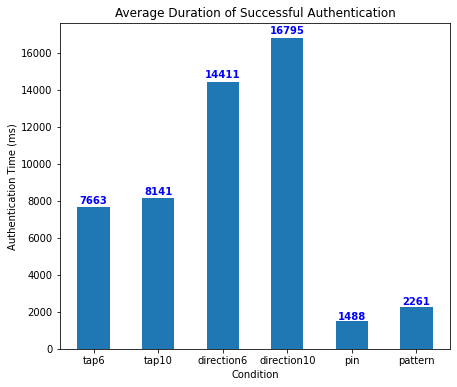

In [6]:
def computeAverageSuccessTime(lst):
    successfulAuths = list(filter(lambda x: x['endState']=='SUCCESS', lst))
    total = 0
    for val in lst:
        total+= val['elapsedTimeInMilliseconds']
    return total/len(successfulAuths)
successRates = {}
for method in methodsDict:
    successRates[method] = computeAverageSuccessTime(methodsDict[method])

fig, ax = plt.subplots(figsize=(7,6))
ax.set_ylabel('Authentication Time (ms)')
ax.set_xlabel('Condition')
ax.set_title('Average Duration of Successful Authentication')

x = list(successRates.keys())
y = list(successRates.values())
rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % round(height),  ha='center', va='bottom', color='blue', fontweight='bold')

### Time Distribution

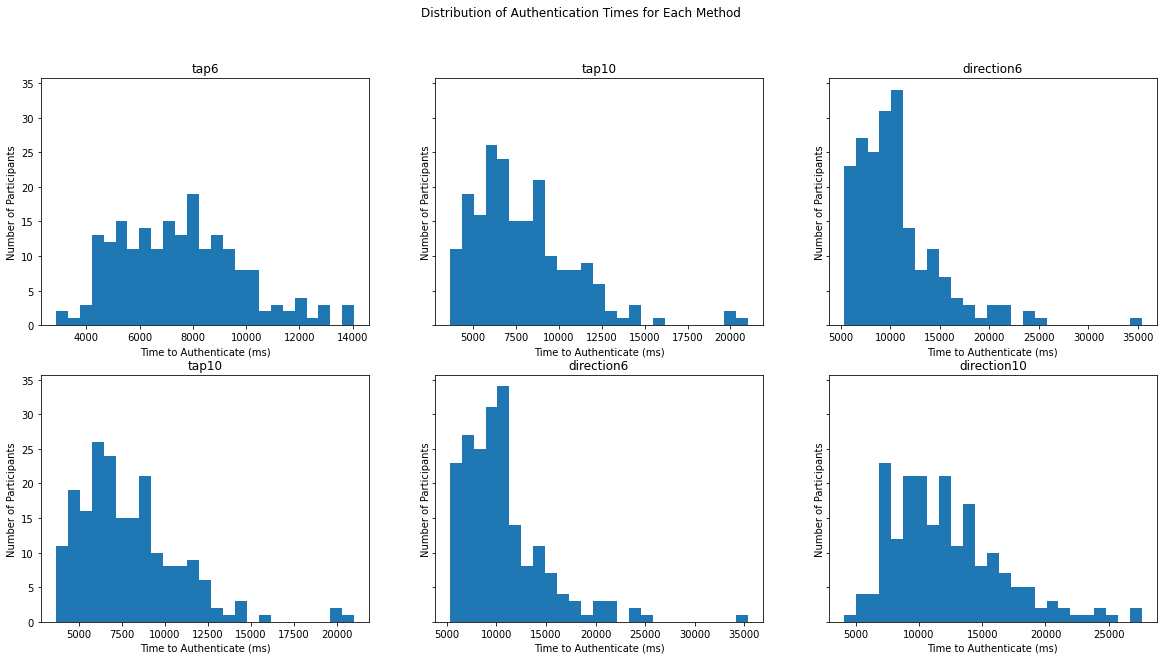

In [7]:
successfulAuths = methodsDict.copy()

for item in successfulAuths:
    successfulAuths[item] = list(filter(lambda x: x['endState']=='SUCCESS', successfulAuths[item]))
successfulAuthsTimeList = list(map(lambda x: {x:list(map(lambda y: y['elapsedTimeInMilliseconds'], successfulAuths[x]))}, successfulAuths))

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20,10))
fig.suptitle('Distribution of Authentication Times for Each Method')

n_bins = 25


for i in range(0,2):
    for j in range(0,3):
        axs[i,j].hist(successfulAuthsTimeList[i+j].values(), bins=n_bins)
        axs[i,j].set_title(list(successfulAuthsTimeList[i+j].keys())[0])
        axs[i,j].set_xlabel('Time to Authenticate (ms)')
        axs[i,j].set_ylabel('Number of Participants')


### Statistical Tests - Repeated Measures One-Way ANOVA

In [8]:
# Parses files and puts data in a format for statistical tests


def getMethod(auth):
    if auth['method'] == 'tap':
        if auth['numTicks'] == '6':
            return 'tap6'
        else:
            return 'tap10'
    elif auth['method'] == 'direction':
        if auth['numTicks'] == '6':
            return 'direction6'
        else:
            return 'direction10'
    elif auth['method'] == 'PATTERN':
        return 'pattern'
    elif auth['method'] == 'PIN':
        return 'PIN'

def fileToTable(i,f, end=None):
    totalRows=[]
    for key in f:
        for auth in f[key]:
            if auth['endState'] != 'ABORTED':
                if end==None:
                    totalRows.append([i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState'], 'null'])
                elif auth['endState'] == end:
                        totalRows.append([i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState'], 'null'])

    return totalRows


def createFileTable(end=None):
    fileTable = [['participant', 'method', 'elapsedTimeInMilliseconds', 'endState', 'errors']]
    for index, file in enumerate(files):
        fileTable += fileToTable(index, file, end)
    return fileTable

totalFileTable = createFileTable()
successFileTable = createFileTable(end='SUCCESS')
failureFileTable = createFileTable(end='FAILURE')


def createTempFileFromTable(fileName, table):
    with open(fileName, 'w') as f:
        for line in table:
            f.write(','.join([str(line[0]), line[1], str(line[2]), str(line[3]), str(line[4]), '\n']))


def mean(lst):
    return sum(lst)/len(lst)

createTempFileFromTable('successTemp.csv', successFileTable)
createTempFileFromTable('failureTemp.csv', failureFileTable)
createTempFileFromTable('totalTemp.csv', totalFileTable)

df = pd.read_csv('successTemp.csv')
print('REPEATED MEASURES ANOVA ON SUCCESS RATE:\n')
print(AnovaRM(df, 'elapsedTimeInMilliseconds', 'participant', within=['method'], aggregate_func=mean).fit())

def createErrorsFile():
    with open('errors.csv', 'w') as f:
        f.write('participant', 'method', 'errors')
        

# meanErrorRatesFromFile('failureTemp.csv')

REPEATED MEASURES ANOVA ON SUCCESS RATE:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 74.5299 5.0000 50.0000 0.0000



In [9]:


# print(f'ANOVA: Number of Errors\nF-statistic: {f_stat_errorCount.statistic}\np-value: {f_stat_errorCount.pvalue}\n\n')
# print(f'ANOVA: Successful Authentication Times\nF-statistic: {f_stat_authTime.statistic}\np-value: {f_stat_authTime.pvalue}')